# Pendulum with Vibrating Base

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# pydrake imports
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, Parser,
                         PlanarSceneGraphVisualizer, Simulator, VectorSystem,
                         Multiplexer, MatrixGain, LogOutput, ConstantVectorSource, 
                         Saturation, WrapToSystem, LinearQuadraticRegulator, SceneGraph, 
                        MultibodyPlant, SignalLogger)

from pydrake.systems.drawing import plot_system_graphviz
from pydrake.examples.acrobot import AcrobotSpongController
from pydrake.systems.analysis import Simulator

# underactuated imports
from underactuated import FindResource, ManipulatorDynamics



## Problem Description
In this problem you will write the controller to make the pendulum with vibrating base spin at constant velocity.
At the end of the notebook, you will be able to check your work in a simulation environment we set up for you.

**These are the main steps of the exercise:**
1. Construct the physical model of the vibrating pendulum. This is done automatically by "parsing" a `.urdf` (Unified Robot Description Format) file.
2. Implement the controller you derived in the written part of this exercise. _This is the only piece of code you will need to write._
3. Wire up the closed-loop block diagram: connect the controller output with the system input, the system output with the visualizer etc.
4. Set up and run a simulation.

## Parse the `.urdf`
The first block of our diagram is the vibrating pendulum.
No need to write its equations of motion by hand: all the parameters of the system are described in its `.urdf` file.
Drake can directly parse this file, and construct a `MultibodyPlant` (i.e. the vibrating-pendulum block in our diagram).
The `.urdf` file contains all the physical data of the system, the visualization parameters (shapes and colors of the bodies), etc.
Its html-like syntax is very easy to understand, give it a try!

Our robot has two bodies:
1. The base. This moves on a 1D rail and oscillates according to the harmonic law $h \sin (\omega t)$.
2. The pendulum. It is connected to the base through a pin. This is the body you will need to control.

**Attention!** Since the robot has two bodies, it also has two configuration variables.
When writing the controller, we will take care of the first (position of the base) and ensure that it oscillates as required.
Then the problem will be reduced to the control of the pendulum only.

[-2.35]
[2.35]


<IPython.core.display.Javascript object>


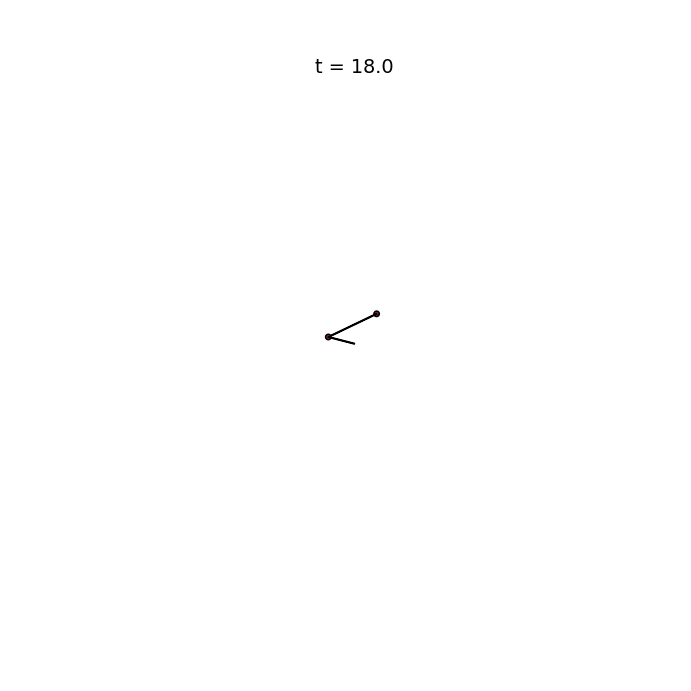

[0. 0. 0. 0.]


<IPython.core.display.Javascript object>


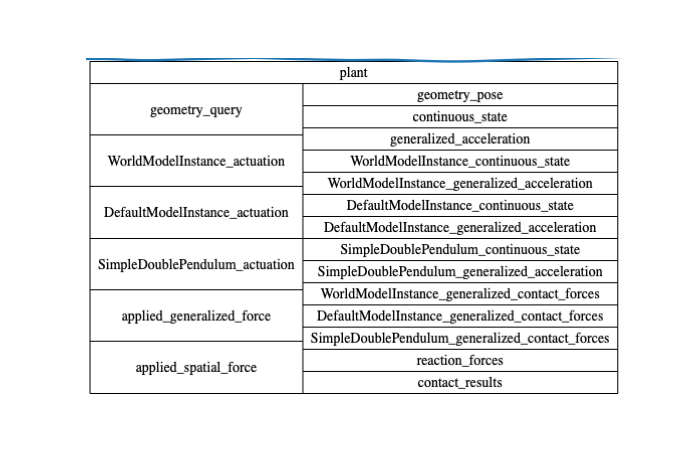

[ 0.00000000e+00  3.12842462e-08  1.12623330e-06 ... -2.27627664e+01
 -2.27183050e+01 -2.26905012e+01]


In [3]:
import os
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram


# double_pendulum = MultibodyPlant(time_step=0.01)
# scene_graph = SceneGraph()
# double_pendulum.RegisterAsSourceForSceneGraph(scene_graph)
# Parser(double_pendulum).AddModelFromFile('double_pendulum_no_shoulder.urdf')
# double_pendulum.Finalize()

#print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_lower_limits()) #applied a limit
#print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_upper_limits()) #applied a limit


double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0 # discrete update period , set to zero since system is continuous
)

#Parser(double_pendulum, scene_graph).AddModelFromFile('double_pendulum_no_shoulder.urdf')
#double_pendulum.Finalize()


#parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()

print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_lower_limits())
print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(2)).position_upper_limits())


# Set the constant torque (you can change the value here if you like)
torque_system = builder.AddSystem(ConstantVectorSource([[0.]]))
# plot_system_graphviz(double_pendulum)
builder.Connect(torque_system.get_output_port(0), double_pendulum.get_input_port(3))
visualizer = builder.AddSystem(
   PlanarSceneGraphVisualizer(scene_graph, xlim=[-10., 10.], ylim=[-10., 10.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
               visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
builder.Connect(double_pendulum.get_state_output_port(), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
print(context.get_state().get_continuous_state().CopyToVector())

plant_context = diagram.GetMutableSubsystemContext(double_pendulum, context)
double_pendulum.SetPositionsAndVelocities(plant_context, [3*np.pi/4, 0, 0, 0])
# Simulate
duration = 18.0 if get_ipython() else 0.1 # sets a shorter duration during testing
context.SetTime(0.0)
# AdvanceToAndVisualize(simulator, visualizer, duration)



fig, ax = plt.subplots()
context.SetTime(0.)
context.SetContinuousState([3*np.pi/4, 0, 0, 0]) #np.random.randn(4,1))
#simulator.AdvanceTo(duration)
AdvanceToAndVisualize(simulator, visualizer, duration)
print(logger.data()[1])
plt.plot(logger.data()[1])
plt.show()

<IPython.core.display.Javascript object>


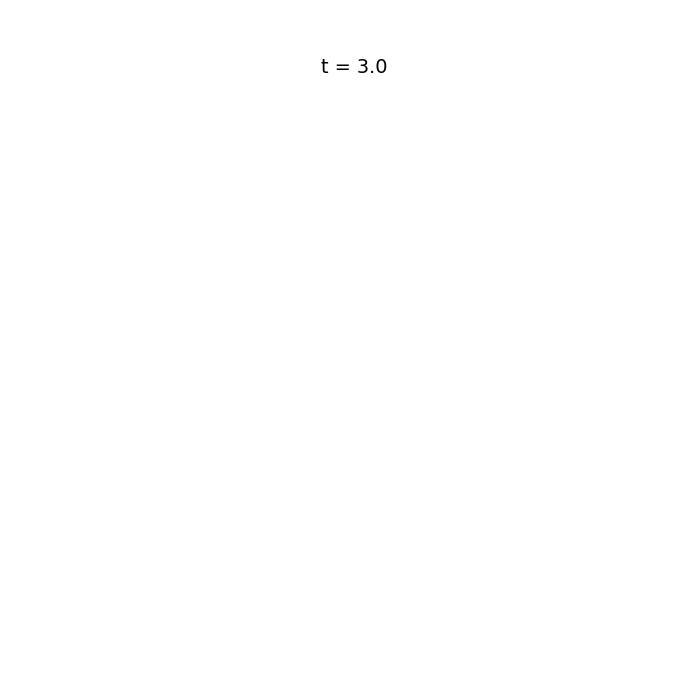

In [4]:
from pydrake.systems.framework import BasicVector


def BalancingLQR(plant):
  
    context = plant.CreateDefaultContext()

    #context.FixInputPort(3, BasicVector([0, 0])) #overrides previous values stored at port if connection already exists
    plant.get_actuation_input_port().FixValue(context, [0])
    context.get_mutable_continuous_state_vector().SetFromVector([np.pi, 0, 0, 0]) # be sure this is an equilibrium point
    
#     upright_state = np.array([np.pi, 0, 0, 0])
#     context.SetContinuousState(upright_state)

#     context.get_mutable_continuous_state_vector()\
#         .SetFromVector(BasicVector(upright_state).CopyToVector())

    Q = np.diag((10., 10., 1., 1.))
    R = [1]
    #R = np.diag((1., 1.))
    
    return LinearQuadraticRegulator(double_pendulum, context, Q, R, input_port_index=3)
    

# think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()

# double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
#     builder,
#     time_step=0.001 # discrete update period , set to zero since system is continuous
# )

# # double_pendulum = MultibodyPlant(time_step=0.001)
# Parser(double_pendulum, scene_graph).AddModelFromFile('double_pendulum_no_shoulder.urdf')
# double_pendulum.Finalize()

plot_system_graphviz(double_pendulum)
saturation = builder.AddSystem(Saturation(min_value=[-100], max_value=[100]))
builder.Connect(saturation.get_output_port(0), double_pendulum.get_actuation_input_port())
wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(double_pendulum.get_state_output_port(), wrapto.get_input_port(0))
plot_system_graphviz(double_pendulum)
controller = builder.AddSystem(BalancingLQR(double_pendulum))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))



# Setup visualization
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-10., 10.], ylim=[-10., 10.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()


# Simulate
duration = 3.0 if get_ipython() else 0.1 # sets a shorter duration during testing
for i in range(1):
    context.SetTime(0.0)
    context.SetContinuousState([np.pi, 0, 0, 0] + 0.05*np.random.randn(4,))
    simulator.Initialize()
    AdvanceToAndVisualize(simulator, visualizer, duration)


In [5]:
# Spong Controller

#get mass matrix
#get ke, kp, kd 
#determine potential + kinetic energy
#E desired = potential energy of first joint + potential energy of second joint

class SpongController(VectorSystem):
    
    def __init__(self, double_pendulum):
        
        # 4 inputs: double pendulum state
        # 1 output: elbow torque
        VectorSystem.__init__(self, 4,  1)
        
        # the controller keeps track of the last value of
        # the elbow torque and the last state of the double pendulum
        self.last_delta = 0
        self.last_state = np.full(4, np.nan)
        
        self.double_pendulum = double_pendulum
        self.double_pendulum_context = double_pendulum.CreateDefaultContext()


        self.k_e = 5
        self.k_p = 50
        self.k_d = 20
        self.length = 1
        self.m1 = 2.4367
        self.m2 = 0.6178
        self.l1 = 0.2563 #length
        self.lc1 = 1.6738 #length to center aka length/2
        self.lc2 = 1.5651
        self.Ic1 = -4.7443 #inertia
        self.Ic2 = -1.0068 
        self.b1 = 0.0320
        self.b2 = 0.0413 
        
    
    # note that this function is called at each time step
    def DoCalcVectorOutput(self, context, state, unused, delta):
        
#         print("Before ", state)
        
#         if state[1] > 3*np.pi/4:
#             state[1] = 3*np.pi/4
#         elif state[1] < -3*np.pi/4:
#             state[1] = -3*np.pi/4
        
#         print("After ", state)
            
        self.double_pendulum_context.SetContinuousState(state)

        M = self.double_pendulum.CalcMassMatrixViaInverseDynamics(self.double_pendulum_context)
        #print("Mass Matrix", M)
        PE = double_pendulum.EvalPotentialEnergy(self.double_pendulum_context)
        #print("PE", PE)
        KE = double_pendulum.EvalKineticEnergy(self.double_pendulum_context)
        #print('KE', KE)
        E = PE + KE
        E_desired = (self.m1*self.lc1 + self.m2*self.lc2)*9.81  
        
        E_tilde = E - E_desired
        u_e = -self.k_e*E_tilde*state[2]
        
        #print(M)
        M = M.astype(float)
        #print(np.linalg.inv(M))
        M_inverse = np.linalg.inv(M)
        y = -self.k_p*state[1] - self.k_d*state[3]
        a3 = M_inverse[1, 1]
        a2 = M_inverse[0, 1]
        a1 = M_inverse[0, 0]
        
        #bias calculation
        
#         s1 = np.sin(state[0])
#         s2 = np.sin(state[1])
#         s12 = np.sin(state[0] + state[1])
        
        
#         m2l1lc2 = self.m2 * self.l1 * self.lc2
#         bias0 = -2*m2l1lc2*s2*state[3]*state[2] - m2l1lc2*s2*state[3]*state[3]
#         bias1 = m2l1lc2 * s2 * state[2]*state[2]
        
#         bias0 += 9.81*self.m1*self.lc1*s1 + 9.81*self.m2*(self.l1*s1 + self.lc2*s12) 
#         bias1 += 9.81*self.m1*self.lc2*s12
        
#         bias0 += self.b1*state[2]
#         bias1 += self.b2*state[3]
        

        
        Cv = self.double_pendulum.CalcBiasTerm(self.double_pendulum_context)
        tauG = self.double_pendulum.CalcGravityGeneralizedForces(self.double_pendulum_context)
        #print()
#         bias0 = Cv[0] + tauG[0]
#         bias1 = Cv[1] + tauG[1]
        
        tau1 = -Cv[0] + tauG[0]
        tau2 = -Cv[1] + tauG[1]
        
        
        #u_p = (a2 * bias0 + y) / a3 + bias1
        
        
        q2d = y + u_e
        u = (M[1, 1]-M[1, 0]*(a1)*(M[0, 1]))*q2d - tau2 + M[1, 0]*(a1)*tau1
        
        
        
        
        # assign value of the preload at each time step
        delta[:] = [u] # modify here
        
        # update controller internal memory
        self.last_delta = delta[0]
        self.last_state = state
        
        
    # feel free to add methods to this class if you need to
    # modify here

In [6]:
#get mass matrix
#get ke, kp, kd 
#determine potential + kinetic energy
#E desired = potential energy of first joint + potential energy of second joint
Vs = []
Es = []
class BanavarController(VectorSystem):
    
    def __init__(self, double_pendulum):
        
        # 4 inputs: double pendulum state
        # 1 output: elbow torque
        VectorSystem.__init__(self, 4,  1)
        
        # the controller keeps track of the last value of
        # the elbow torque and the last state of the double pendulum
        self.last_delta = 0
        self.last_state = np.full(4, np.nan)
        
        self.double_pendulum = double_pendulum
        self.double_pendulum_context = double_pendulum.CreateDefaultContext()
        
        self.k_e = 0.005
        self.k_p = 1
        self.k_d = 1
        self.length = 1
        self.m1 = 1 #2.4367
        self.m2 = 2 #0.6178
        self.lc1 = 0.5 #1.6738 #length to center aka length/2
        self.lc2 = 1 #1.5651
        self.l1 = self.lc1*2 #length
        self.Ic1 = -4.7443 #inertia
        self.Ic2 = -1.0068 
        self.b1 = 0.0320
        self.b2 = 0.0413 


    def DoCalcVectorOutput(self, context, state, unused, delta):
            
        self.double_pendulum_context.SetContinuousState(state)

        M = self.double_pendulum.CalcMassMatrixViaInverseDynamics(self.double_pendulum_context)
        #print("Mass Matrix", M)
        PE = double_pendulum.EvalPotentialEnergy(self.double_pendulum_context)
        #print("State: ", state)
        print("PE: ", PE)
        KE = double_pendulum.EvalKineticEnergy(self.double_pendulum_context)
        print('KE', KE)
        E = PE + KE
        
        E_desired = 68.67 
        E_desired = (self.m1*self.lc1 + self.m2*(self.lc2 + self.l1))*9.81  
        print("E", E)
        print("E_desired", E_desired)
        E_tilde = E - E_desired
        
        
        ### Lyapunov ###
        V = 0.5*(self.k_p*state[1]**2 + self.k_d*state[3]**2 + self.k_e*E_tilde**2)
        Vs.append(V)
        Es.append(E)
        
        #print(M)
        M = M.astype(float)
        #print(np.linalg.inv(M))
        M_inverse = np.linalg.inv(M)
        
        Cv = self.double_pendulum.CalcBiasTerm(self.double_pendulum_context)
        #print("Cv")
        #print(Cv)
        tauG = self.double_pendulum.CalcGravityGeneralizedForces(self.double_pendulum_context)
        #print("tauG")
        #print(tauG)
        
        f4 = M_inverse.dot(-Cv + tauG)[1]
        #print("f4")
        #print(f4)
        B = np.array([[0], [1]])
        g4 = (M_inverse.dot(B))[1]
        #print("g4", g4)
        u = -(state[3] + self.k_p*state[1] + self.k_d*f4) / (self.k_d*g4 + self.k_e*E_tilde)
        
        # assign value of the preload at each time step
        delta[:] = [u] # modify here
        
        # update controller internal memory
        self.last_delta = delta[0]
        self.last_state = state

<IPython.core.display.Javascript object>


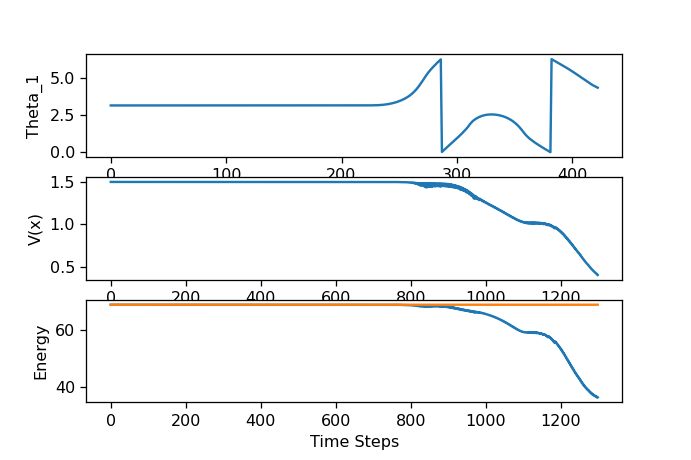

PE:  68.67
KE 0.0
E 68.67
E_desired 44.145
PE:  68.67
KE 4.478518549997821e-39
E 68.67
E_desired 44.145
PE:  68.67
KE 1.7914071867939354e-38
E 68.67
E_desired 44.145
PE:  68.67
KE 1.7914073015160545e-38
E 68.67
E_desired 44.145
PE:  68.67
KE 2.194473839045703e-37
E 68.67
E_desired 44.145
PE:  68.67
KE 6.449062258143549e-37
E 68.67
E_desired 44.145
PE:  68.67
KE 6.4490639502786526e-37
E 68.67
E_desired 44.145
PE:  68.67
KE 6.131087339500112e-36
E 68.67
E_desired 44.145
PE:  68.67
KE 1.7215353252607548e-35
E 68.67
E_desired 44.145
PE:  68.67
KE 1.7215373258524282e-35
E 68.67
E_desired 44.145
PE:  68.67
KE 1.5660842021944572e-34
E 68.67
E_desired 44.145
PE:  68.67
KE 4.359400410411969e-34
E 68.67
E_desired 44.145
PE:  68.67
KE 4.3594140179523776e-34
E 68.67
E_desired 44.145
PE:  68.67
KE 3.931701230133381e-33
E 68.67
E_desired 44.145
PE:  68.67
KE 1.0919957717419805e-32
E 68.67
E_desired 44.145
PE:  68.67
KE 1.0919429727865897e-32
E 68.67
E_desired 44.145
PE:  68.67
KE 2.9361457404400244e

E_desired 44.145
PE:  68.67
KE 2.898114079002867e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 2.925719392793244e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 2.6513321376984944e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 2.337720308549126e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 2.3637024944630517e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 2.092677746669977e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.7899384188094142e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.8137444597169863e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.555026619516016e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.2738877515571979e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.294881404122854e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 1.0591177072216936e-30
E 68.67
E_desired 44.145
PE:  68.67
KE 8.122581445276715e-31
E 68.67
E_desired 44.145
PE:  68.67
KE 8.297097747760838e-31
E 68.67
E_desired 44.145
PE:  68.67
KE 6.294704203180517e-31
E 68.67
E_desired 44.145
PE:  68.67
KE 4.317692762991138e-31
E 68.67
E_desired 44.145
P

KE 6.216435899884395e-24
E 68.67
E_desired 44.145
PE:  68.67
KE 7.434070050266125e-24
E 68.67
E_desired 44.145
PE:  68.67
KE 9.284479124346073e-24
E 68.67
E_desired 44.145
PE:  68.67
KE 9.037410241130881e-24
E 68.67
E_desired 44.145
PE:  68.67
KE 1.0808652624370394e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 1.3501313613734e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 1.314109735462581e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 1.5716145773980077e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 1.9631251853638725e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 1.9107256417516788e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 2.285171338120926e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 2.85457339869011e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 2.7782522260838367e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 3.3228618138632883e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 4.1511349387994803e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 4.0400805622961644e-23
E 68.67
E_desired 44.145
PE:  68.67
KE 4.83192893502815

PE:  68.67
KE 8.648631263063623e-16
E 68.67
E_desired 44.145
PE:  68.67
KE 8.417479725653321e-16
E 68.67
E_desired 44.145
PE:  68.67
KE 1.0067918908059845e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 1.257759876968518e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 1.224143811017921e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 1.4641652017868076e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 1.8291448922618672e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 1.780257479070812e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 2.1293177147338175e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 2.6601033678089686e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 2.5890069574790435e-15
E 68.67
E_desired 44.145
PE:  68.67
KE 3.0966410873059713e-15
E 68.67
E_desired 44.145
PE:  68.66999999999999
KE 3.868556294325346e-15
E 68.66999999999999
E_desired 44.145
PE:  68.66999999999999
KE 3.765161647173649e-15
E 68.66999999999999
E_desired 44.145
PE:  68.66999999999999
KE 4.503407902086163e-15
E 68.66999999999999
E_desired 44.145
PE:  6

E 68.6699998690576
E_desired 44.145
PE:  68.66998761777302
KE 1.2225610306650888e-05
E 68.66999984338332
E_desired 44.145
PE:  68.66998453119103
KE 1.5273151605755857e-05
E 68.66999980434264
E_desired 44.145
PE:  68.6699849446253
KE 1.486494669105117e-05
E 68.66999980957199
E_desired 44.145
PE:  68.6699819926722
KE 1.777956200784419e-05
E 68.66999977223422
E_desired 44.145
PE:  68.66997750389228
KE 2.221156551457414e-05
E 68.66999971545779
E_desired 44.145
PE:  68.66997810514486
KE 2.1617917924539218e-05
E 68.66999972306279
E_desired 44.145
PE:  68.66997381215417
KE 2.5856608745336824e-05
E 68.66999966876291
E_desired 44.145
PE:  68.66996728417436
KE 3.2302019222883366e-05
E 68.66999958619358
E_desired 44.145
PE:  68.66996815856892
KE 3.143868457323571e-05
E 68.6699995972535
E_desired 44.145
PE:  68.66996191532313
KE 3.76029627072758e-05
E 68.66999951828583
E_desired 44.145
PE:  68.66995242175928
KE 4.697644689666544e-05
E 68.66999939820617
E_desired 44.145
PE:  68.6699536933809
KE 4.5

PE:  1.5520520892457075
KE 66.51380609387179
E 68.0658581831175
E_desired 44.145
PE:  9.878921505176644
KE 58.3901578512472
E 68.26907935642384
E_desired 44.145
PE:  6.457919417574005
KE 61.84399622448018
E 68.30191564205418
E_desired 44.145
PE:  2.6219251388189195
KE 65.48934052752394
E 68.11126566634286
E_desired 44.145
PE:  2.821037357151106
KE 65.43969133813853
E 68.26072869528964
E_desired 44.145
PE:  -0.8230628889270849
KE 69.12960472292994
E 68.30654183400286
E_desired 44.145
PE:  -4.866133935471084
KE 72.93707042714786
E 68.07093649167678
E_desired 44.145
PE:  -4.664952345340231
KE 72.9239148336779
E 68.25896248833767
E_desired 44.145
PE:  -8.490892209833735
KE 76.81059763952007
E 68.31970542968634
E_desired 44.145
PE:  -12.684278999023586
KE 80.7141293835962
E 68.02985038457261
E_desired 44.145
PE:  -12.485793081271664
KE 80.74958607530918
E 68.26379299403752
E_desired 44.145
PE:  -16.43542410092105
KE 84.776449234185
E 68.34102513326394
E_desired 44.145
PE:  -20.7039907205551

KE 3.536838809459465
E 64.89015540773329
E_desired 44.145
PE:  61.67901810958134
KE 3.1470874673572458
E 64.82610557693859
E_desired 44.145
PE:  61.90358583618533
KE 2.823571030987033
E 64.72715686717237
E_desired 44.145
PE:  61.94806892028926
KE 2.8013582837829367
E 64.74942720407219
E_desired 44.145
PE:  62.206152775783295
KE 2.476224784484276
E 64.68237756026757
E_desired 44.145
PE:  62.375191392067464
KE 2.205347855037039
E 64.5805392471045
E_desired 44.145
PE:  62.41479873312896
KE 2.1879244182607804
E 64.60272315138974
E_desired 44.145
PE:  62.61462674190015
KE 1.9180196581554365
E 64.53264640005558
E_desired 44.145
PE:  62.73551382177675
KE 1.6922575071409784
E 64.42777132891773
E_desired 44.145
PE:  62.77105695272568
KE 1.6788904913956948
E 64.44994744412138
E_desired 44.145
PE:  62.9204761626794
KE 1.4563314398607392
E 64.37680760254014
E_desired 44.145
PE:  62.99931691568765
KE 1.26946600989665
E 64.2687829255843
E_desired 44.145
PE:  63.03150497551178
KE 1.2594970146922386
E

E_desired 44.145
PE:  -54.361166180777985
KE 107.18103077740574
E 52.81986459662775
E_desired 44.145
PE:  -54.354470108905204
KE 107.26284803991358
E 52.908377931008374
E_desired 44.145
PE:  -55.306807371398975
KE 107.93904285398608
E 52.632235482587106
E_desired 44.145
PE:  -56.231069447774054
KE 108.44828639675546
E 52.21721694898141
E_desired 44.145
PE:  -56.22553788379038
KE 108.53212082262849
E 52.306582938838105
E_desired 44.145
PE:  -57.10449616289246
KE 109.12489429764939
E 52.02039813475693
E_desired 44.145
PE:  -57.95142129463535
KE 109.5467254542249
E 51.595304159589546
E_desired 44.145
PE:  -57.94697062248009
KE 109.632204176922
E 51.685233554441915
E_desired 44.145
PE:  -58.74794460232409
KE 110.13853890605587
E 51.39059430373178
E_desired 44.145
PE:  -59.51327417521998
KE 110.47076122412591
E 50.957487048905925
E_desired 44.145
PE:  -59.50980620963373
KE 110.55750739102965
E 51.047701181395915
E_desired 44.145
PE:  -60.22859901470072
KE 110.97491023586679
E 50.74631122116

In [7]:
   # think of the builder as the construction site of our block diagram
builder = DiagramBuilder()

# instantiate the vibrating pendulum and the scene graph
# the scene graph is a container for the geometries of all the physical systems in our diagram
double_pendulum, scene_graph = AddMultibodyPlantSceneGraph(
    builder,
    time_step=0. # discrete update period , set to zero since system is continuous
)

# parse the urdf and populate the vibrating pendulum
urdf_path = 'double_pendulum_no_shoulder.urdf'
Parser(double_pendulum).AddModelFromFile(urdf_path)
double_pendulum.Finalize()
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_lower_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_lower_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_upper_limits())
# print(double_pendulum.get_joint(pydrake.multibody.tree.JointIndex(0)).position_upper_limits())



saturation = builder.AddSystem(Saturation(min_value=[-100], max_value=[100]))
builder.Connect(saturation.get_output_port(0), double_pendulum.get_actuation_input_port())
wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(double_pendulum.get_state_output_port(), wrapto.get_input_port(0))
#plot_system_graphviz(double_pendulum)
controller = builder.AddSystem(BanavarController(double_pendulum))
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))



# Setup visualization
# visualizer = builder.AddSystem(
#    PlanarSceneGraphVisualizer(scene_graph, xlim=[-10., 10.], ylim=[-10., 10.], show=plt_is_interactive))
# builder.Connect(scene_graph.get_pose_bundle_output_port(),
#                visualizer.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
builder.Connect(wrapto.get_output_port(0), logger.get_input_port(0))
diagram = builder.Build()
plot_system_graphviz(diagram)


# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
plant_context = diagram.GetMutableSubsystemContext(double_pendulum, context)
double_pendulum.SetPositionsAndVelocities(plant_context, [np.pi, 0, 0, 0])

# Simulate
duration = 30.0 if get_ipython() else 0.1 # sets a shorter duration during testing



fig, ax = plt.subplots(3)
context.SetTime(0.)
context.SetContinuousState([np.pi, 0, 0, 0]) #np.random.randn(4,1))
simulator.AdvanceTo(duration)
#AdvanceToAndVisualize(simulator, visualizer, duration)
ax[0].plot(logger.data()[0][0:1300])
ax[0].set_xlabel("Time Steps")
ax[0].set_ylabel("Theta_1")
ax[1].plot(Vs[0:1300])
ax[1].set_xlabel("Time Steps")
ax[1].set_ylabel("V(x)")
# ax[2].plot(logger.data()[0][0:400], logger.data()[2][0:400])
# ax[2].set_xlabel("Theta_1")
# ax[2].set_ylabel("dTheta_1/dt")
ax[2].plot(Es[0:1300])
ax[2].plot([68.67]*1300)
ax[2].set_xlabel("Time Steps")
ax[2].set_ylabel("Energy")
plt.show()



# plt.figure(figsize=(9, 3))
# plt.subplot(131)
# plt.plot(logger.data()[0])
# plt.xlabel("Time Steps")
# plt.ylabel("Theta_1")
# plt.subplot(132)
# plt.plot(Vs)
# plt.show()


# for i in range(1):
#     context.SetTime(0.0)
#     #context.SetContinuousState([3*np.pi/4, 0, 0, 0] + 0.05*np.random.randn(4,))
#     simulator.Initialize()
#     AdvanceToAndVisualize(simulator, visualizer, duration)

#state over time plot

1075
